Import all necessary libraries and install everything you need for training:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# install the libraries necessary for data wrangling, prediction and result analysis
import json
import numpy as np
import pandas as pd
import logging
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, f1_score,precision_score, recall_score
import torch
from numba import cuda
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier

# Install transformers
# (this needs to be done on Kaggle each time you start the session)
!pip install -q transformers

# Install the simpletransformers
!pip install -q simpletransformers
from simpletransformers.classification import ClassificationModel

# Install wandb
!pip install -q wandb
import wandb

# Login to wandb
wandb.login()

     |████████████████████████████████| 4.7 MB 9.1 MB/s 
     |████████████████████████████████| 6.6 MB 52.2 MB/s 
     |████████████████████████████████| 120 kB 54.7 MB/s 
     |████████████████████████████████| 249 kB 7.1 MB/s 
     |████████████████████████████████| 365 kB 56.3 MB/s 
     |████████████████████████████████| 9.1 MB 56.2 MB/s 
     |████████████████████████████████| 43 kB 1.9 MB/s 
     |████████████████████████████████| 1.3 MB 57.1 MB/s 
     |████████████████████████████████| 1.8 MB 56.9 MB/s 
     |████████████████████████████████| 157 kB 41.2 MB/s 
     |████████████████████████████████| 181 kB 68.2 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
     |████████████████████████████████| 157 kB 49.2 MB/s 
     |████████████████████████████████| 157 kB 66.1 MB/s 
     |████████████████████████████████| 157 kB 64.5 MB/s 
     |████████████████████████████████| 157 kB 74.3 MB/s 
     |████████████████████████████████| 156 kB 64.7 MB/s 
     |██████████████

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [3]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [4]:
# Initialize Wandb
run = wandb.init(project="X-GENRE classifiers", entity="tajak", name="testing-trained-model")

wandb: Currently logged in as: tajak. Use `wandb login --relogin` to force relogin


### Import the data

In [5]:
# SI-GINCO
si_ginco_test = pd.read_csv("/content/drive/MyDrive/GitHub/Genre-Datasets-Comparison/data-splits/GINCO-SL-X-GENRE-test.csv", index_col = 0)
si_ginco_dev = pd.read_csv("/content/drive/MyDrive/GitHub/Genre-Datasets-Comparison/data-splits/GINCO-SL-X-GENRE-dev.csv", index_col = 0)

# Import MT-GINCO test file
mt_ginco_test = pd.read_csv("/content/drive/MyDrive/GitHub/Genre-Datasets-Comparison/data-splits/MT-GINCO-X-GENRE-test.csv", index_col = 0)
mt_ginco_test = mt_ginco_test.drop(columns=["split"])

# MT-GINCO dev file
mt_ginco_dev = pd.read_csv("/content/drive/MyDrive/GitHub/Genre-Datasets-Comparison/data-splits/MT-GINCO-X-GENRE-dev.csv", index_col = 0)
mt_ginco_dev = mt_ginco_dev.drop(columns=["split"])

# Import CORE-X-GENRE test file
core_test = pd.read_csv("/content/drive/MyDrive/GitHub/Genre-Datasets-Comparison/data-splits/CORE-sample-X-GENRE-test.csv", index_col=0)
core_dev = pd.read_csv("/content/drive/MyDrive/GitHub/Genre-Datasets-Comparison/data-splits/CORE-sample-X-GENRE-dev.csv", index_col = 0)

# Import FTD test file
ftd_test = pd.read_csv("/content/drive/MyDrive/GitHub/Genre-Datasets-Comparison/data-splits/FTD-X-GENRE-test.txt", sep = "\t", index_col = 0)

# Import the joint dataset test file
x_genre_test = pd.read_csv("/content/drive/MyDrive/GitHub/Genre-Datasets-Comparison/data-splits/X-GENRE-test.csv", sep = "\t", index_col = 0)
x_genre_dev = pd.read_csv("/content/drive/MyDrive/GitHub/Genre-Datasets-Comparison/data-splits/X-GENRE-dev.csv", sep = "\t", index_col = 0)

print(f"Data shape: si-ginco-test: {si_ginco_test.shape}, si-ginco-dev: {si_ginco_dev.shape}")
print(f"mt-ginco-test: {mt_ginco_test.shape}, mt-ginco-dev: {mt_ginco_dev.shape}")
print(f"core_test: {core_test.shape}, core_dev: {core_dev.shape}")
print(f"ftd_test: {ftd_test.shape}")
print(f"x_genre_test: {x_genre_test.shape}, x_genre_dev: {x_genre_dev.shape}")

x_genre_dev

Data shape: si-ginco-test: (179, 2), si-ginco-dev: (179, 2)
mt-ginco-test: (179, 2), mt-ginco-dev: (179, 2)
core_test: (203, 2), core_dev: (203, 2)
ftd_test: (210, 2)
x_genre_test: (592, 2), x_genre_dev: (592, 2)


,text,labels
0,"Yesterday, for the first time in 9 years, I em...",Opinion/Argumentation
1,Enjoy fun science experiments for kids that fe...,Instruction
2,It is said that human resource professionals o...,Instruction
3,This year will be a boom year -- for scaremong...,Opinion/Argumentation
4,Mark Twain is said to have remarked that a gol...,Instruction
...,...,...
587,Tabs let you organize gadgets into groups Tabs...,Instruction
588,RESEARCH DEVELOPMENT & RESULTS from Extensive ...,Promotion
589,N. 6 : A Protein Crystallographic Toolbox : CC...,News
590,High House is a small Victorian stone built co...,Promotion


In [6]:
# Open the main results file:

previous_results = pd.read_csv("/content/drive/MyDrive/GitHub/Genre-Datasets-Comparison/results/X-GENRE-Experiments-Results.csv", sep="\t", index_col = 0)

previous_results

,experiment,microF1,macroF1,y_true,y_pred,trained_on,tested_on
0,testing-FTD-X-GENRE-on-SL-GINCO-test,0.569832,0.498112,"{228: 'News', 12: 'Opinion/Argumentation', 617...","{228: 'Instruction', 12: 'Information/Explanat...",FTD,SL-GINCO
1,testing-FTD-X-GENRE-on-MT-GINCO-test,0.569832,0.457568,"{2: 'Promotion', 3: 'News', 12: 'Opinion/Argum...","{2: 'Promotion', 3: 'News', 12: 'Information/E...",FTD,MT-GINCO
2,testing-FTD-X-GENRE-on-CORE-test,0.477833,0.397299,"{216: 'Forum', 41678: 'Forum', 7171: 'News', 9...","{216: 'Opinion/Argumentation', 41678: 'Instruc...",FTD,CORE
3,testing-FTD-X-GENRE-on-dev,0.814286,0.827740,"{409: 'Instruction', 1051: 'Legal', 1473: 'Pro...","{409: 'Information/Explanation', 1051: 'Legal'...",FTD,FTD-dev
4,testing-FTD-X-GENRE-on-test,0.842857,0.851374,"{439: 'Promotion', 1576: 'Promotion', 913: 'Pr...","{439: 'Promotion', 1576: 'Promotion', 913: 'Pr...",FTD,FTD-test
5,testing-FTD-X-GENRE-on-X-GENRE-test,0.635135,0.532467,"{0: 'Forum', 1: 'Forum', 2: 'News', 3: 'Prose/...","{0: 'Opinion/Argumentation', 1: 'Instruction',...",FTD,X-GENRE-test
6,MT-GINCO-classifier-tested-on-MT-GINCO-test,0.743017,0.722785,"{2: 'Promotion', 3: 'News', 12: 'Opinion/Argum...","{2: 'News', 3: 'News', 12: 'Other', 15: 'News'...",MT-GINCO,MT-GINCO-test
7,MT-GINCO-classifier-tested-on-SI-GINCO-test,0.731844,0.655184,"{228: 'News', 12: 'Opinion/Argumentation', 617...","{228: 'News', 12: 'Other', 617: 'Promotion', 2...",MT-GINCO,SI-GINCO-test
8,MT-GINCO-classifier-tested-on-CORE-test,0.660099,0.552608,"{216: 'Forum', 41678: 'Forum', 7171: 'News', 9...","{216: 'Forum', 41678: 'Instruction', 7171: 'Ne...",MT-GINCO,CORE-test
9,MT-GINCO-classifier-tested-on-FTD-test,0.736318,0.718093,"{439: 'Promotion', 1576: 'Promotion', 913: 'Pr...","{439: 'Other', 1576: 'Promotion', 913: 'Prose/...",MT-GINCO,FTD-test


In [7]:
# Load the trained model from Wandb
model_name = "tajak/X-GENRE classifiers/X-GENRE-classifier"
# Use the latest version of the model
model_at = run.use_artifact(model_name + ":latest")
# Download the directory
model_dir = model_at.download()

# Loading a local save
model = ClassificationModel(
    "xlmroberta", model_dir)

wandb: Downloading large artifact X-GENRE-classifier:latest, 1081.88MB. 8 files... Done. 0:0:11.6
/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:476: UserWarning: use_multiprocessing automatically disabled as xlmroberta fails when using multiprocessing for feature conversion.
  f"use_multiprocessing automatically disabled as {model_type}"


In [8]:
def testing(test_df, trained_on, tested_on):
    """
    This function takes the test dataset and applies the trained model on it to infer predictions.
    It also prints and saves a confusion matrix, calculates the F1 scores and saves the results in to previous results (a dataframe).

    Args:
    - test_df (pandas DataFrame)
    - trained_on: e.g. "CORE", "SL-GINCO" etc.
    - tested_on : e.g. "CORE", "GINCO" etc.
    """
    # Get the true labels
    y_true = test_df.labels

    LABELS = test_df.labels.unique().tolist()

    # Calculate the model's predictions on test
    def make_prediction(input_string):
        return model.predict([input_string])[0][0]

    y_pred = test_df.text.apply(make_prediction)
    test_df["y_pred"] = y_pred

    # Calculate the scores
    macro = f1_score(y_true, y_pred, labels=LABELS, average="macro")
    micro = f1_score(y_true, y_pred, labels=LABELS,  average="micro")
    print(f"Macro f1: {macro:0.3}, Micro f1: {micro:0.3}")

    # Plot the confusion matrix:
    cm = confusion_matrix(y_true, y_pred, labels=LABELS)
    plt.figure(figsize=(9, 9))
    plt.imshow(cm, cmap="Oranges")
    for (i, j), z in np.ndenumerate(cm):
        plt.text(j, i, '{:d}'.format(z), ha='center', va='center')
    classNames = LABELS
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=90)
    plt.yticks(tick_marks, classNames)
    plt.title(f"{trained_on}-classifier-tested-on-{tested_on}")

    plt.tight_layout()
    fig1 = plt.gcf()
    plt.show()
    plt.draw()
    fig1.savefig(f"/content/drive/MyDrive/GitHub/Genre-Datasets-Comparison/results/Confusion-matrix-{trained_on}-classifier-tested-on-{tested_on}.png",dpi=100)

    # Append Row to DataFrame
    list_row = [f"{trained_on}-classifier-tested-on-{tested_on}", micro, macro, y_true.to_dict(), y_pred.to_dict(), trained_on, tested_on]
    previous_results.loc[len(previous_results)] = list_row

    # Save the new dataframe which contains the y_pred values as well
    test_df.to_csv(f"/content/drive/MyDrive/GitHub/Genre-Datasets-Comparison/results/{trained_on}-classifier-tested-on-{tested_on}-sheet-with-predictions.csv", sep="\t")

## MT-GINCO classifier

Macro f1: 0.723, Micro f1: 0.743


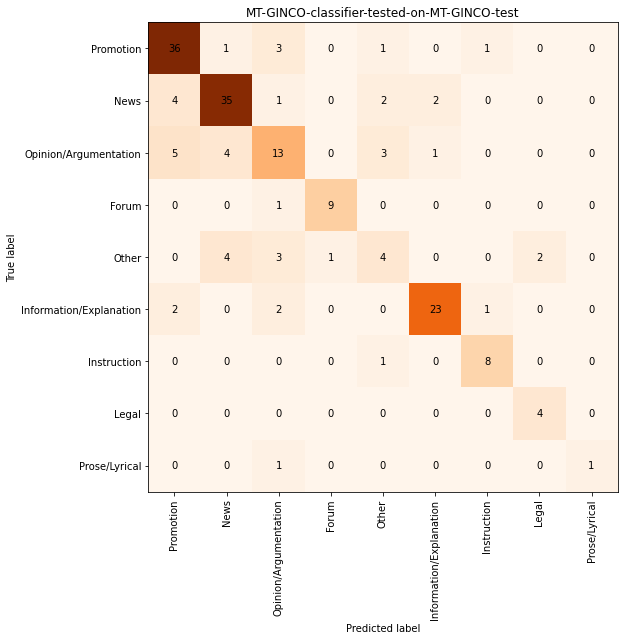

Macro f1: 0.655, Micro f1: 0.732


<Figure size 432x288 with 0 Axes>

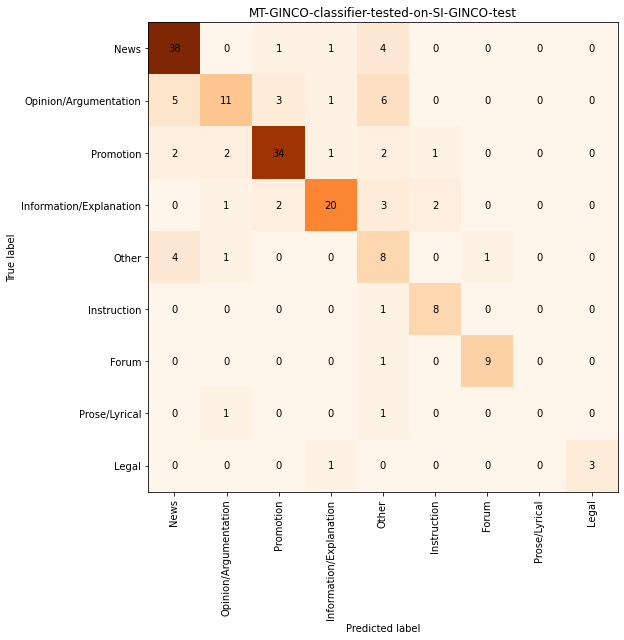

Macro f1: 0.553, Micro f1: 0.66


<Figure size 432x288 with 0 Axes>

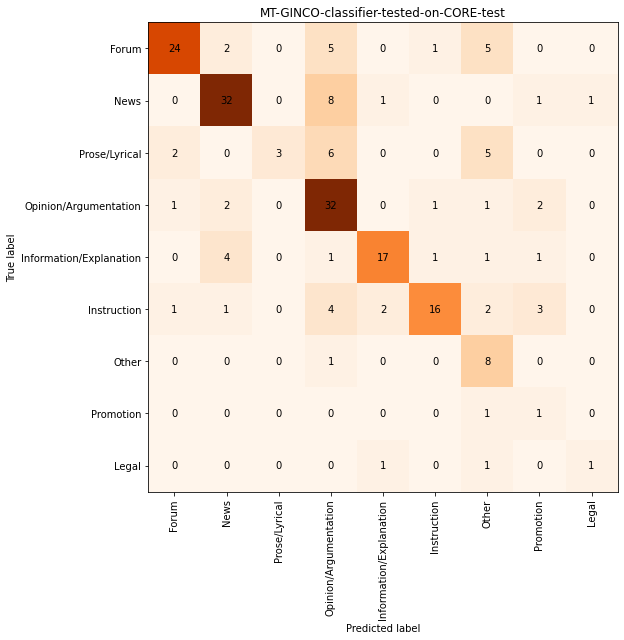

Macro f1: 0.718, Micro f1: 0.736


<Figure size 432x288 with 0 Axes>

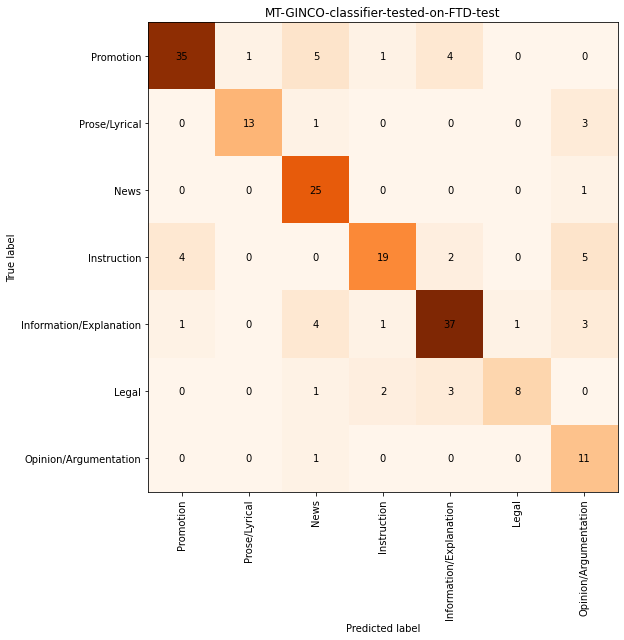

Macro f1: 0.667, Micro f1: 0.698


<Figure size 432x288 with 0 Axes>

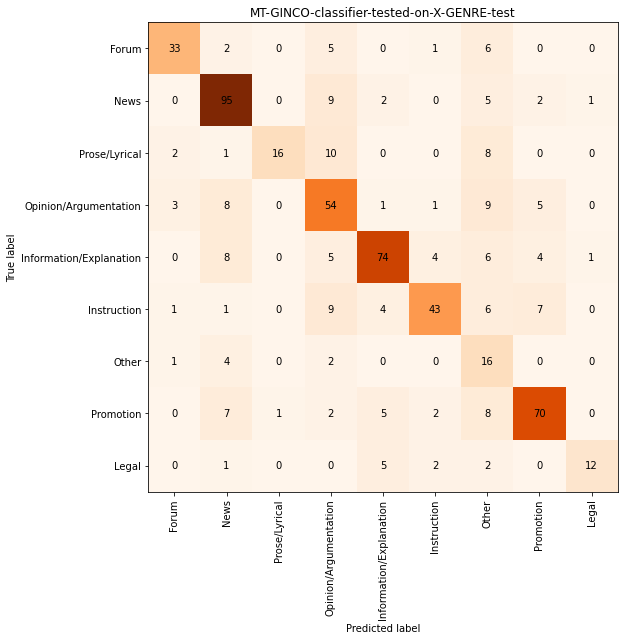

<Figure size 432x288 with 0 Axes>

In [ ]:
# Apply classifier on all datasets:
for i in [[mt_ginco_test, "MT-GINCO-test"], [si_ginco_test, "SI-GINCO-test"], [core_test, "CORE-test"], [ftd_test, "FTD-test"], [x_genre_test, "X-GENRE-test"]]:
  testing(i[0], "MT-GINCO", i[1])

Macro f1: 0.759, Micro f1: 0.765


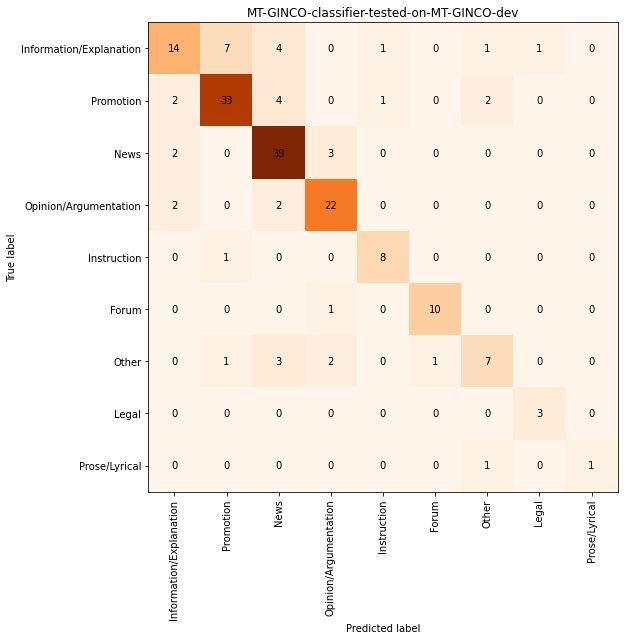

<Figure size 432x288 with 0 Axes>

In [ ]:
testing(mt_ginco_dev, "MT-GINCO", "MT-GINCO-dev")

## SL-GINCO

Macro f1: 0.582, Micro f1: 0.67


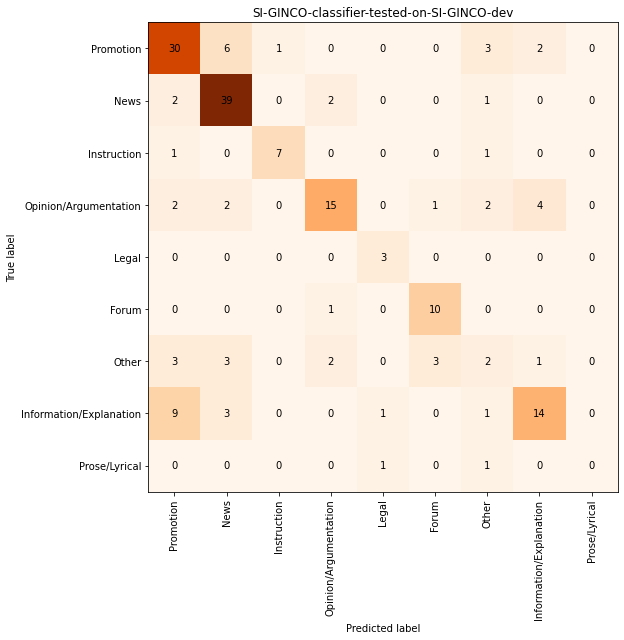

Macro f1: 0.75, Micro f1: 0.754


<Figure size 432x288 with 0 Axes>

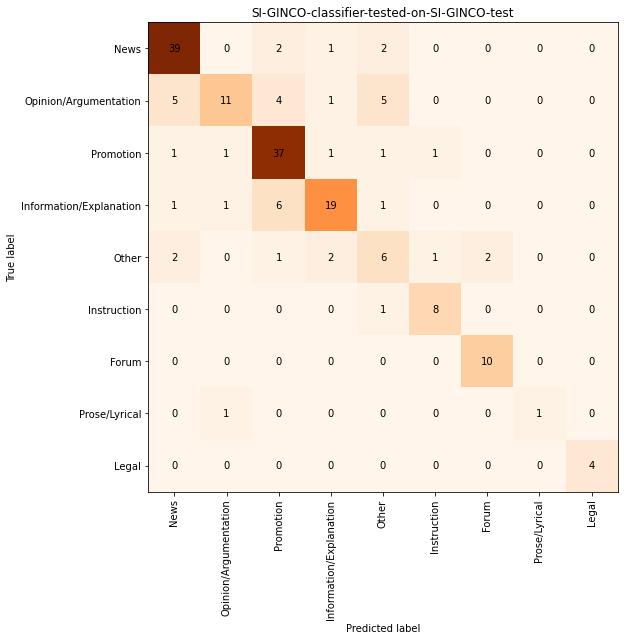

Macro f1: 0.596, Micro f1: 0.676


<Figure size 432x288 with 0 Axes>

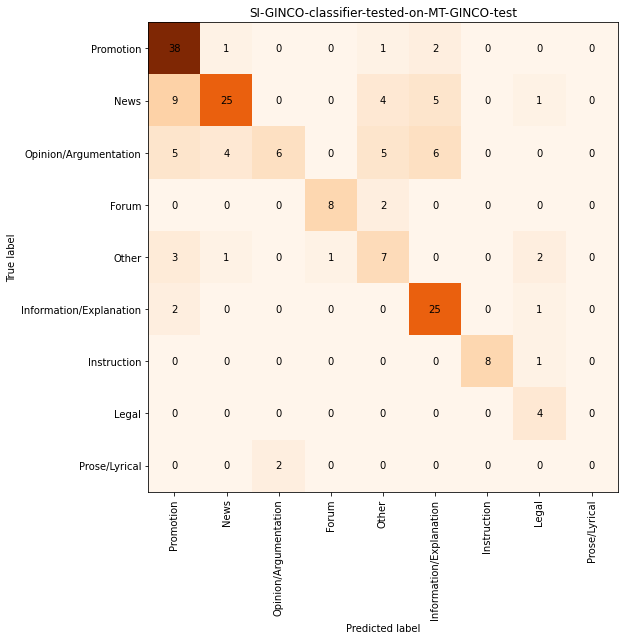

Macro f1: 0.521, Micro f1: 0.591


<Figure size 432x288 with 0 Axes>

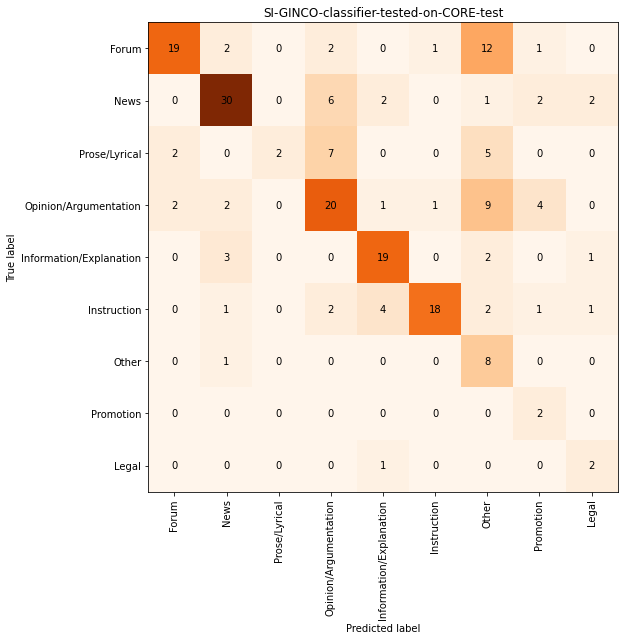

Macro f1: 0.654, Micro f1: 0.726


<Figure size 432x288 with 0 Axes>

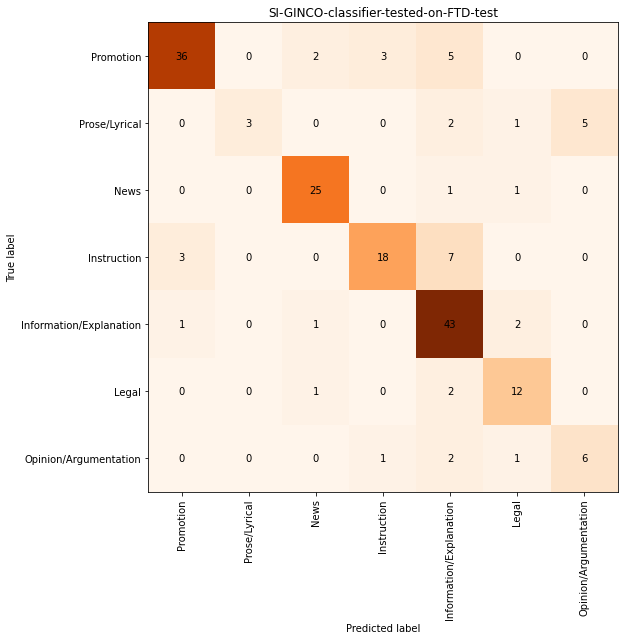

Macro f1: 0.617, Micro f1: 0.672


<Figure size 432x288 with 0 Axes>

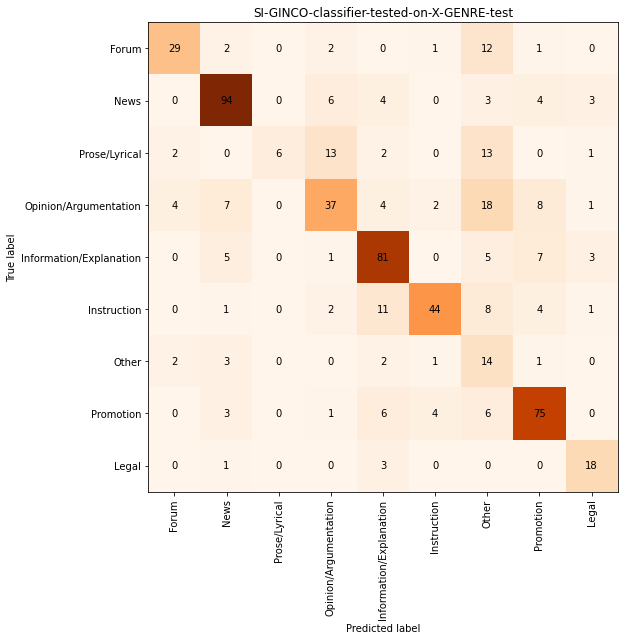

<Figure size 432x288 with 0 Axes>

In [ ]:
# Apply classifier on all datasets:
for i in [[si_ginco_dev, "SI-GINCO-dev"],[si_ginco_test, "SI-GINCO-test"], [mt_ginco_test, "MT-GINCO-test"], [core_test, "CORE-test"], [ftd_test, "FTD-test"], [x_genre_test, "X-GENRE-test"]]:
  testing(i[0], "SI-GINCO", i[1])

## CORE classifier

Macro f1: 0.609, Micro f1: 0.764


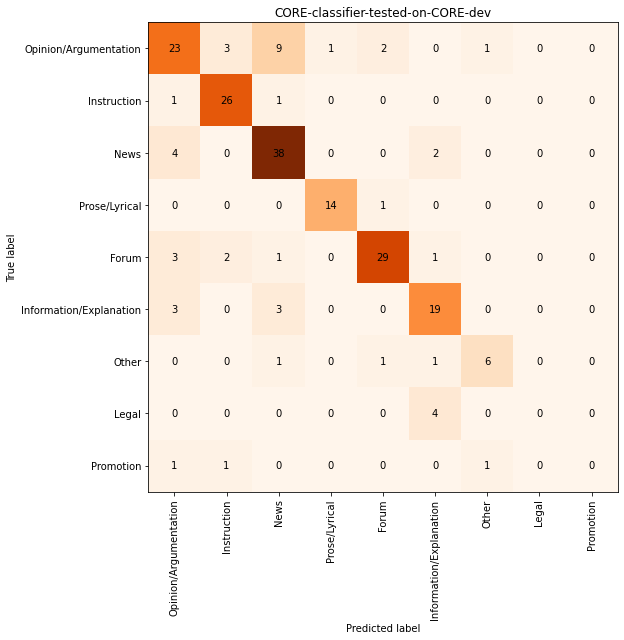

Macro f1: 0.627, Micro f1: 0.778


<Figure size 432x288 with 0 Axes>

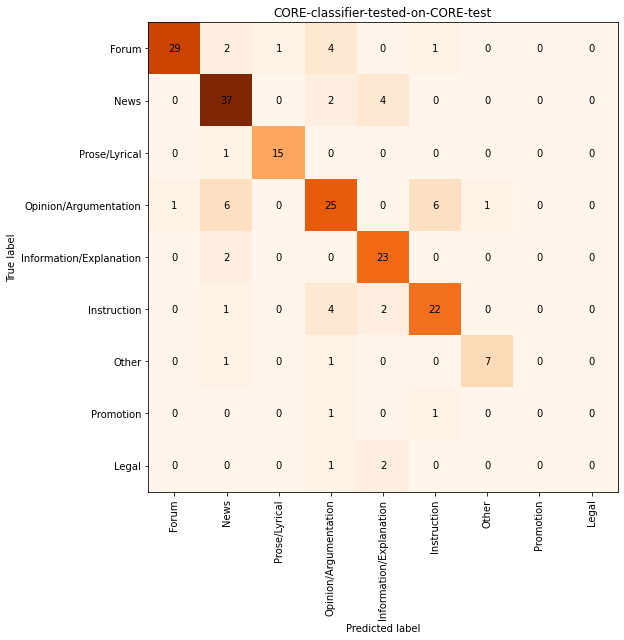

Macro f1: 0.348, Micro f1: 0.374


<Figure size 432x288 with 0 Axes>

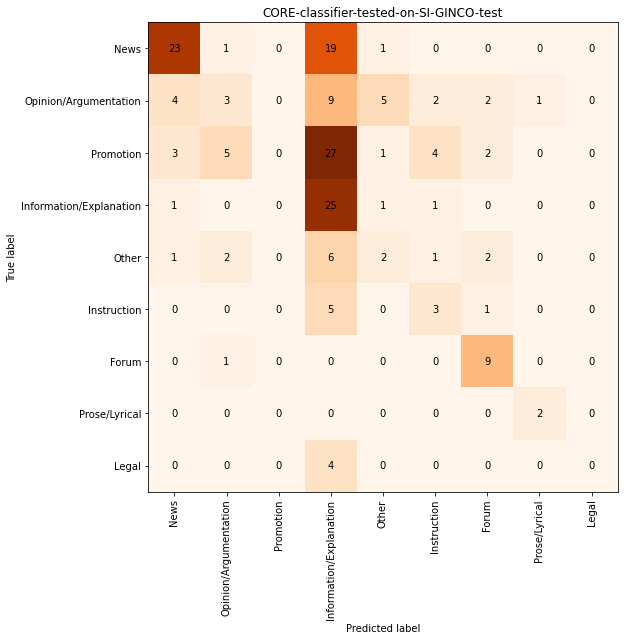

Macro f1: 0.394, Micro f1: 0.385


<Figure size 432x288 with 0 Axes>

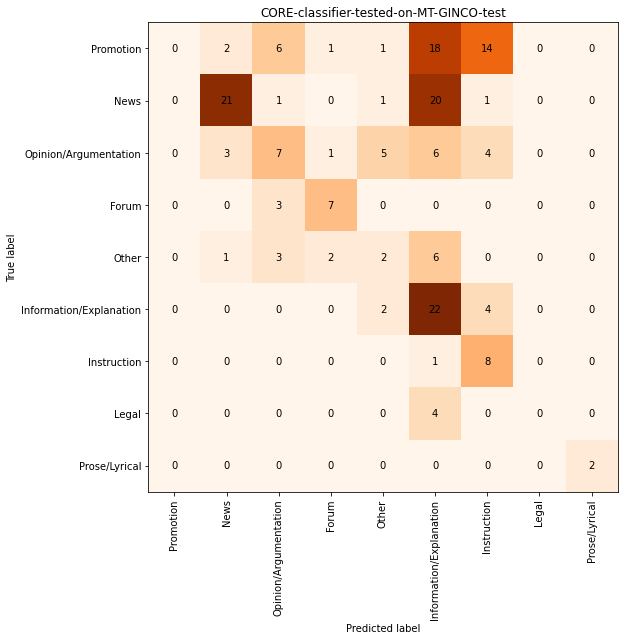

Macro f1: 0.419, Micro f1: 0.495


<Figure size 432x288 with 0 Axes>

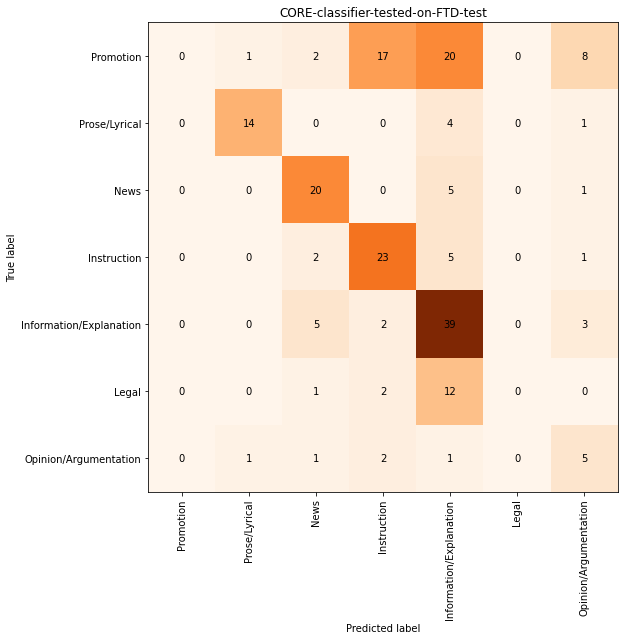

Macro f1: 0.481, Micro f1: 0.551


<Figure size 432x288 with 0 Axes>

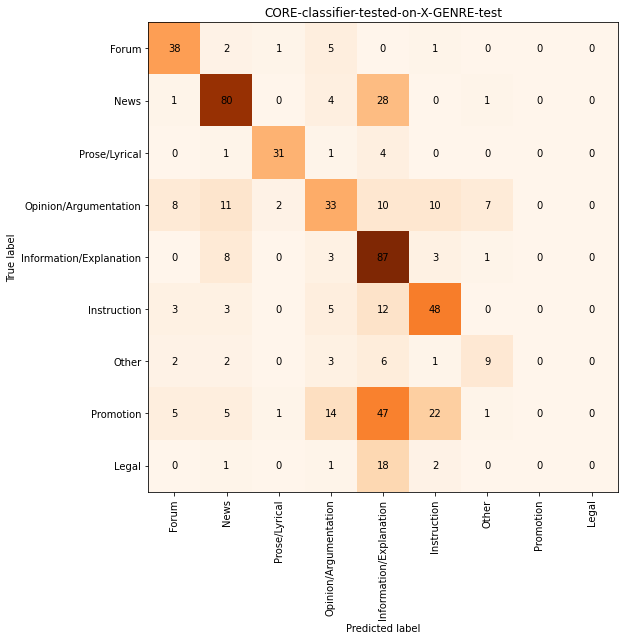

<Figure size 432x288 with 0 Axes>

In [ ]:
# Apply classifier on all datasets:
for i in [[core_dev, "CORE-dev"], [core_test, "CORE-test"], [si_ginco_test, "SI-GINCO-test"], [mt_ginco_test, "MT-GINCO-test"], [ftd_test, "FTD-test"], [x_genre_test, "X-GENRE-test"]]:
  testing(i[0], "CORE", i[1])

## X-GENRE classifier

Macro f1: 0.784, Micro f1: 0.784


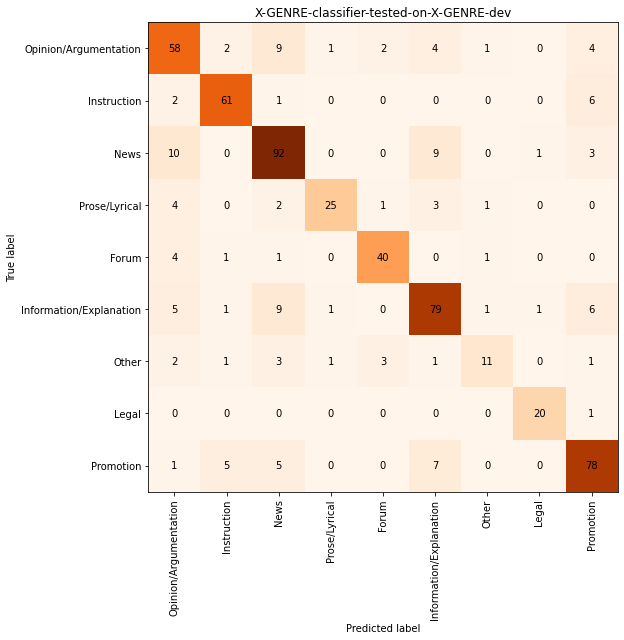

Macro f1: 0.794, Micro f1: 0.797


<Figure size 432x288 with 0 Axes>

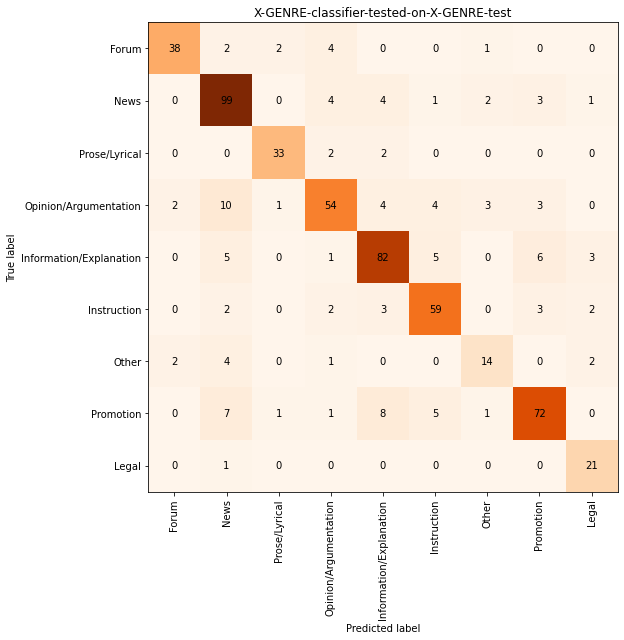

Macro f1: 0.859, Micro f1: 0.837


<Figure size 432x288 with 0 Axes>

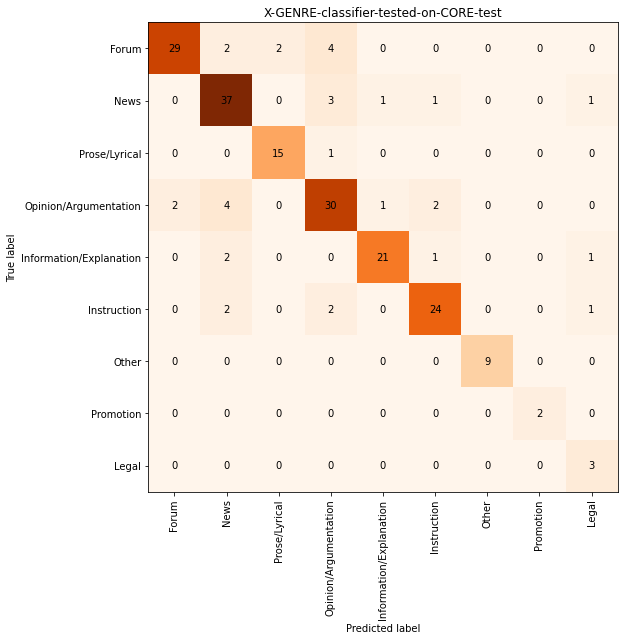

Macro f1: 0.758, Micro f1: 0.749


<Figure size 432x288 with 0 Axes>

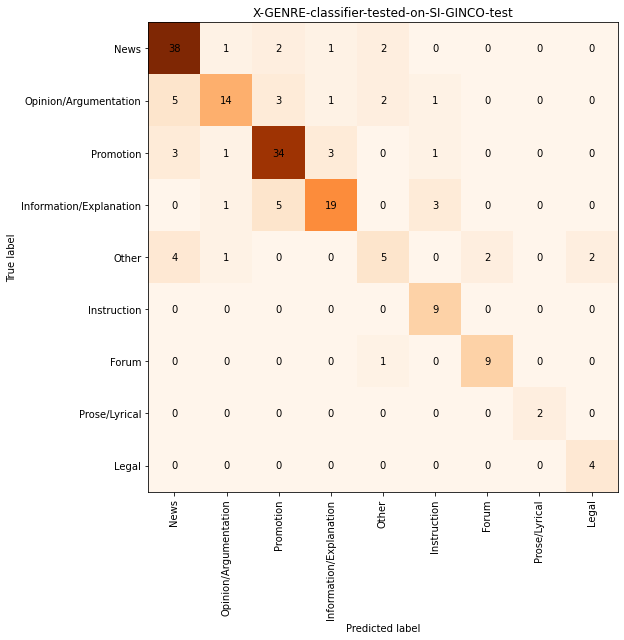

Macro f1: 0.676, Micro f1: 0.698


<Figure size 432x288 with 0 Axes>

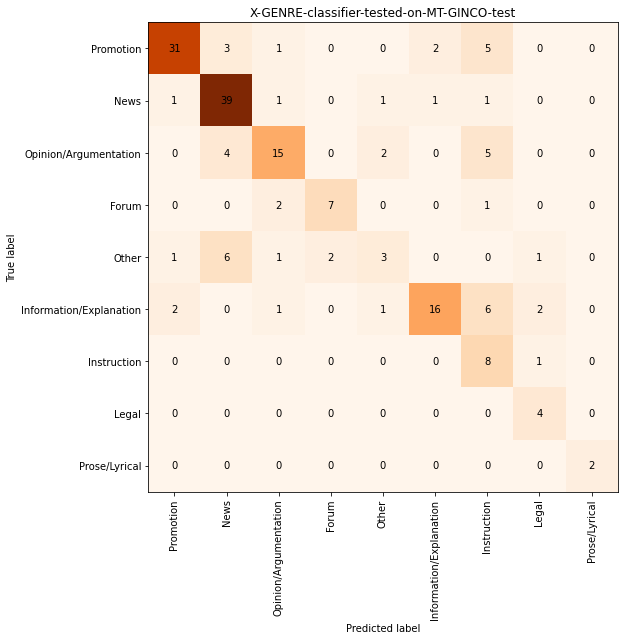

Macro f1: 0.809, Micro f1: 0.804


<Figure size 432x288 with 0 Axes>

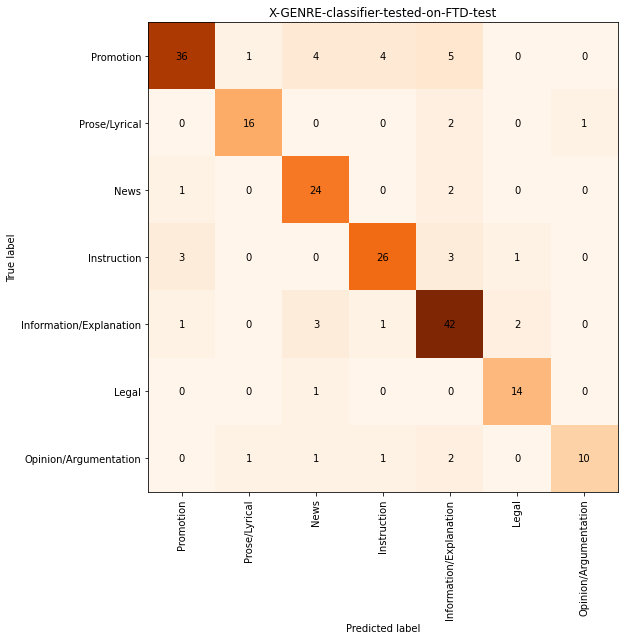

<Figure size 432x288 with 0 Axes>

In [9]:
# Apply classifier on all datasets:
for i in [[x_genre_dev, "X-GENRE-dev"], [x_genre_test, "X-GENRE-test"], [core_test, "CORE-test"], [si_ginco_test, "SI-GINCO-test"], [mt_ginco_test, "MT-GINCO-test"], [ftd_test, "FTD-test"]]:
  testing(i[0], "X-GENRE", i[1])

In [10]:
previous_results

,experiment,microF1,macroF1,y_true,y_pred,trained_on,tested_on
0,testing-FTD-X-GENRE-on-SL-GINCO-test,0.569832,0.498112,"{228: 'News', 12: 'Opinion/Argumentation', 617...","{228: 'Instruction', 12: 'Information/Explanat...",FTD,SL-GINCO
1,testing-FTD-X-GENRE-on-MT-GINCO-test,0.569832,0.457568,"{2: 'Promotion', 3: 'News', 12: 'Opinion/Argum...","{2: 'Promotion', 3: 'News', 12: 'Information/E...",FTD,MT-GINCO
2,testing-FTD-X-GENRE-on-CORE-test,0.477833,0.397299,"{216: 'Forum', 41678: 'Forum', 7171: 'News', 9...","{216: 'Opinion/Argumentation', 41678: 'Instruc...",FTD,CORE
3,testing-FTD-X-GENRE-on-dev,0.814286,0.827740,"{409: 'Instruction', 1051: 'Legal', 1473: 'Pro...","{409: 'Information/Explanation', 1051: 'Legal'...",FTD,FTD-dev
4,testing-FTD-X-GENRE-on-test,0.842857,0.851374,"{439: 'Promotion', 1576: 'Promotion', 913: 'Pr...","{439: 'Promotion', 1576: 'Promotion', 913: 'Pr...",FTD,FTD-test
5,testing-FTD-X-GENRE-on-X-GENRE-test,0.635135,0.532467,"{0: 'Forum', 1: 'Forum', 2: 'News', 3: 'Prose/...","{0: 'Opinion/Argumentation', 1: 'Instruction',...",FTD,X-GENRE-test
6,MT-GINCO-classifier-tested-on-MT-GINCO-test,0.743017,0.722785,"{2: 'Promotion', 3: 'News', 12: 'Opinion/Argum...","{2: 'News', 3: 'News', 12: 'Other', 15: 'News'...",MT-GINCO,MT-GINCO-test
7,MT-GINCO-classifier-tested-on-SI-GINCO-test,0.731844,0.655184,"{228: 'News', 12: 'Opinion/Argumentation', 617...","{228: 'News', 12: 'Other', 617: 'Promotion', 2...",MT-GINCO,SI-GINCO-test
8,MT-GINCO-classifier-tested-on-CORE-test,0.660099,0.552608,"{216: 'Forum', 41678: 'Forum', 7171: 'News', 9...","{216: 'Forum', 41678: 'Instruction', 7171: 'Ne...",MT-GINCO,CORE-test
9,MT-GINCO-classifier-tested-on-FTD-test,0.736318,0.718093,"{439: 'Promotion', 1576: 'Promotion', 913: 'Pr...","{439: 'Other', 1576: 'Promotion', 913: 'Prose/...",MT-GINCO,FTD-test


In [11]:
# Save the file with results
previous_results.to_csv("/content/drive/MyDrive/GitHub/Genre-Datasets-Comparison/results/X-GENRE-Experiments-Results.csv", sep="\t")